# Deep Criminal Sketch Artist - Attempt 2
###  References
Model:
https://arxiv.org/pdf/1802.05335.pdf
https://github.com/mhw32/multimodal-vae-public

Activation:
https://arxiv.org/abs/1710.05941

Product of experts:
https://arxiv.org/pdf/1410.7827.pdf

ELBO Loss:
https://arxiv.org/abs/1312.6114

### Setup

In [1]:
# Imports
import os
import sys
import random
import numpy as np
import numpy.random as npr
from PIL import Image
from random import shuffle
import math 
# Pytorch
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch.nn import functional as F
# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Check if running on GPU

In [2]:
dtype = torch.float
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


### Set path to where CelebA is downloaded
Needs to include everything here: https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8

In [3]:
dataset_path = '/home/sci/jadie/Data/CelebA/'

### Define dataset class with images and attributes

In [4]:
PARTITIONS = {'train': 0, 'val': 1, 'test': 2}

class CelebAttributes(Dataset):
    def __init__(self, partition='train', data_dir='/home/sci/jadie/Data/CelebA/'):
        self.partition = partition
        self.data_dir = data_dir
        self.image_paths = load_eval_partition(partition, data_dir=data_dir)
        self.attr_data = load_attributes(self.image_paths, partition, data_dir=data_dir)
        self.size = int(len(self.image_paths))

    def __getitem__(self, index):
        image_path = os.path.join(self.data_dir, 'img_align_celeba', self.image_paths[index])
        attr = self.attr_data[index]
        image = Image.open(image_path).convert('RGB')
        image_transform = transforms.Compose([transforms.Resize(64),transforms.CenterCrop(64),transforms.ToTensor()])
        image =image_transform(image)
        return image, attr

    def __len__(self):
        return self.size


def load_eval_partition(partition, data_dir='/home/sci/jadie/Data/CelebA/'):
    eval_data = []
    with open(os.path.join(data_dir, 'Eval/list_eval_partition.txt')) as fp:
        rows = fp.readlines()
        for row in rows:
            path, label = row.strip().split(' ')
            label = int(label)
            if label == PARTITIONS[partition]:
                eval_data.append(path)
    return eval_data


def load_attributes(paths, partition, data_dir='/home/sci/jadie/Data'):
    attr_data = []
    with open(os.path.join(data_dir, 'Anno/list_attr_celeba.txt')) as fp:
        rows = fp.readlines()
        for ix, row in enumerate(rows[2:]):
            row = row.strip().split()
            path, attrs = row[0], row[1:]
            if path in paths:
                attrs = np.array(attrs).astype(int)
                attrs[attrs < 0] = 0
                attr_data.append(attrs)
    attr_data = np.vstack(attr_data).astype(np.int64)
    attr_data = torch.from_numpy(attr_data).float()
    return attr_data

### Get train and validation loaders
This takes a little while to run

In [5]:
celeba_train = CelebAttributes(partition='train', data_dir=dataset_path)
train_loader = torch.utils.data.DataLoader(celeba_train, batch_size=100, shuffle=True)
print("Number of training examples: " + str(len(celeba_train)))

celeba_val = CelebAttributes(partition='val', data_dir=dataset_path)
val_loader = torch.utils.data.DataLoader(celeba_val, batch_size=100, shuffle=False)
print("Number of validation examples: " + str(len(celeba_val)))

celeba_test = CelebAttributes(partition='test', data_dir=dataset_path)
test_loader = torch.utils.data.DataLoader(celeba_test, batch_size=100, shuffle=False)
print("Number of test examples: " + str(len(celeba_test)))

Number of training examples: 162770
Number of validation examples: 19867
Number of test examples: 19962


#### Visualize a batch of training images

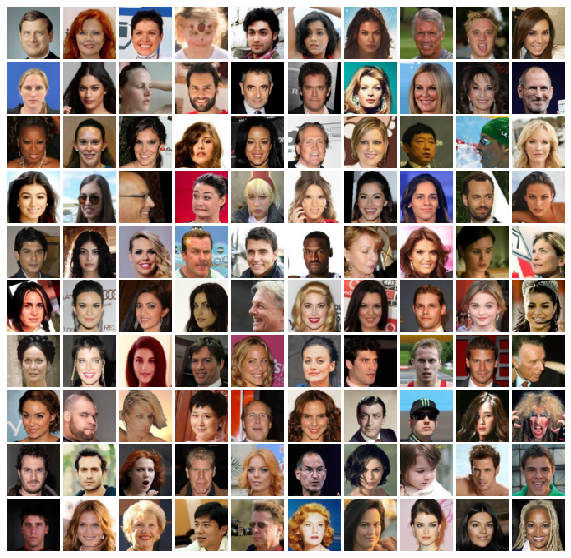

In [6]:
def show_images(images):
  sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
  sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

  fig = plt.figure(figsize=(sqrtn, sqrtn))
  gs = gridspec.GridSpec(sqrtn, sqrtn)
  gs.update(wspace=0.05, hspace=0.05)

  for i, img in enumerate(images):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(img.permute(1,2,0))
  return 

imgs = train_loader.__iter__().next()[0].view(100, 3, 64, 64)
show_images(imgs)

## Define Model

In [7]:
# Activation
class Swish(nn.Module):
    """https://arxiv.org/abs/1710.05941"""
    def forward(self, x):
        return x * torch.sigmoid(x)

In [8]:
# q(z|image)
class ImageEncoder(nn.Module):
    def __init__(self, n_latents):
        super(ImageEncoder, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            Swish(),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            Swish(),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            Swish(),
            nn.Conv2d(128, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            Swish())
        self.classifier = nn.Sequential(
            nn.Linear(256 * 5 * 5, 512),
            Swish(),
            nn.Dropout(p=0.1),
            nn.Linear(512, n_latents * 2))
        self.n_latents = n_latents

    def forward(self, x):
        n_latents = self.n_latents
        x = self.features(x)
        x = x.view(-1, 256 * 5 * 5)
        x = self.classifier(x)
        return x[:, :n_latents], x[:, n_latents:]

In [9]:
# p(image|z)
class ImageDecoder(nn.Module):
    def __init__(self, n_latents):
        super(ImageDecoder, self).__init__()
        self.upsample = nn.Sequential(
            nn.Linear(n_latents, 256 * 5 * 5),
            Swish())
        self.reconstruct = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            Swish(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            Swish(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            Swish(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False))
    def forward(self, z):
        z = self.upsample(z)
        z = z.view(-1, 256, 5, 5)
        x_hat = self.reconstruct(z)
        return x_hat

In [10]:
# q(z|attrs)
class AttributeEncoder(nn.Module):
    def __init__(self, n_latents):
        super(AttributeEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(40, 512),
            nn.BatchNorm1d(512),
            Swish(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            Swish(),
            nn.Linear(512, n_latents * 2))
        self.n_latents = n_latents
    def forward(self, x):
        n_latents = self.n_latents
        x = self.net(x)
        return x[:, :n_latents], x[:, n_latents:]

In [11]:
# p(attrs|z)
class AttributeDecoder(nn.Module):
    def __init__(self, n_latents):
        super(AttributeDecoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_latents, 512),
            nn.BatchNorm1d(512),
            Swish(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            Swish(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            Swish(),
            nn.Linear(512, 40))
    def forward(self, z):
        z = self.net(z)
        return z

In [12]:
class ProductOfExperts(nn.Module):
    """Return parameters for product of independent experts.
    Equations from https://arxiv.org/pdf/1410.7827.pdf for equations.
    """
    def forward(self, mu, logvar, eps=1e-8):
        var       = torch.exp(logvar) + eps
        # precision of i-th Gaussian expert at point x
        T         = 1. / var
        pd_mu     = torch.sum(mu * T, dim=0) / torch.sum(T, dim=0)
        pd_var    = 1. / torch.sum(T, dim=0)
        pd_logvar = torch.log(pd_var)
        return pd_mu, pd_logvar

In [13]:
def prior_expert(size, use_cuda=False):
    """Universal prior expert. Here we use a spherical
    Gaussian: N(0, 1).
    """
    mu     = Variable(torch.zeros(size))
    logvar = Variable(torch.log(torch.ones(size)))
    if use_cuda:
        mu, logvar = mu.cuda(), logvar.cuda()
    return mu, logvar

In [60]:
class MVAE(nn.Module):
    """Multimodal Variational Autoencoder."""
    def __init__(self, n_latents):
        super(MVAE, self).__init__()
        self.image_encoder = ImageEncoder(n_latents)
        self.image_decoder = ImageDecoder(n_latents)
        self.attrs_encoder = AttributeEncoder(n_latents)
        self.attrs_decoder = AttributeDecoder(n_latents)
        self.experts       = ProductOfExperts()
        self.n_latents     = n_latents

    def reparametrize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:  # return mean during inference
            return mu

    def forward(self, image=None, attrs=None):
        mu, logvar  = self.infer(image, attrs)
        # reparametrization trick to sample
        z           = self.reparametrize(mu, logvar)
        # reconstruct inputs based on that gaussian
        image_recon = self.image_decoder(z)
        attrs_recon = self.attrs_decoder(z)
        return image_recon, attrs_recon, mu, logvar

    def infer(self, image=None, attrs=None): 
        batch_size = image.size(0) if image is not None else attrs.size(0)
        use_cuda   = next(self.parameters()).is_cuda  # check if CUDA
        # initialize the universal prior expert
        mu, logvar = prior_expert((1, batch_size, self.n_latents), 
                                  use_cuda=use_cuda)
        if image is not None:
            image_mu, image_logvar = self.image_encoder(image)
            mu     = torch.cat((mu, image_mu.unsqueeze(0)), dim=0)
            logvar = torch.cat((logvar, image_logvar.unsqueeze(0)), dim=0)

        if attrs is not None:
            attrs_mu, attrs_logvar = self.attrs_encoder(attrs)
            mu     = torch.cat((mu, attrs_mu.unsqueeze(0)), dim=0)
            logvar = torch.cat((logvar, attrs_logvar.unsqueeze(0)), dim=0)

        # product of experts to combine gaussians
        mu, logvar = self.experts(mu, logvar)
        return mu, logvar


### Define training

In [32]:
def elbo_loss(recon_image, image, recon_attrs, attrs, mu, logvar,
              lambda_image=1.0, lambda_attrs=1.0, annealing_factor=1):
    """Bimodal ELBO loss function. """
    image_bce, attrs_bce = 0, 0  # default params
    
    if recon_image is not None and image is not None:
        image_bce = torch.sum(binary_cross_entropy_with_logits(
            recon_image.view(-1, 3 * 64 * 64), 
            image.view(-1, 3 * 64 * 64)), dim=1)

    if recon_attrs is not None and attrs is not None:
        for i in range(40):
            attr_bce = binary_cross_entropy_with_logits(
                recon_attrs[:, i], attrs[:, i])
            attrs_bce += attr_bce

    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    ELBO = torch.mean(lambda_image * image_bce + lambda_attrs * attrs_bce 
                      + annealing_factor * KLD)
    return ELBO

def binary_cross_entropy_with_logits(input, target):
    """Sigmoid Activation + Binary Cross Entropy"""
    return (torch.clamp(input, 0) - input * target 
            + torch.log(1 + torch.exp(-torch.abs(input))))


# For getting avergae loss of epoch
class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_epoch(mvae_model, epoch):
    mvae_model.train()
    train_loss_meter = AverageMeter()
    train_MSE_meter = AverageMeter()
    N_mini_batches = len(train_loader)
    lambda_image =1
    lambda_attrs = 10
    for batch_idx, (image, attrs) in enumerate(train_loader):
        if epoch < 20:
            # compute the KL annealing factor for the current mini-batch in the current epoch
            annealing_factor = (float(batch_idx + (epoch - 1) * N_mini_batches + 1) / float(20 * N_mini_batches))
        else:
            # by default the KL annealing factor is unity
            annealing_factor = 1.0
        image = Variable(image.cuda())
        attrs = Variable(attrs.cuda())
        optimizer.zero_grad()
        recon_image_1, recon_attrs_1, mu_1, logvar_1 = mvae_model(image, attrs)
        recon_image_2, recon_attrs_2, mu_2, logvar_2 = mvae_model(image)
        recon_image_3, recon_attrs_3, mu_3, logvar_3 = mvae_model(attrs=attrs)
        MSE = torch.mean((image-recon_image_3)**2)
        train_MSE_meter.update(MSE.item(), len(image))
        # compute ELBO for each data combo
        joint_loss = elbo_loss(recon_image_1, image, recon_attrs_1, attrs, mu_1, logvar_1, 
                            lambda_image=lambda_image, lambda_attrs=lambda_attrs, annealing_factor=annealing_factor)
        image_loss = elbo_loss(recon_image_2, image, None, None, mu_2, logvar_2, 
                            lambda_image=lambda_image, lambda_attrs=lambda_attrs, annealing_factor=annealing_factor)
        attrs_loss = elbo_loss(None, None, recon_attrs_3, attrs, mu_3, logvar_3, 
                            lambda_image=lambda_image, lambda_attrs=lambda_attrs, annealing_factor=annealing_factor)
        train_loss = joint_loss + image_loss + attrs_loss
        train_loss_meter.update(train_loss.item(), len(image))
        # compute and take gradient step
        train_loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTaskMSE: {:.6f}'.format(
                epoch, batch_idx * len(image), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss_meter.avg, train_MSE_meter.avg))
    print('====> Epoch: {}\tLoss: {:.4f}\tTaskMSE: {:.6f}'.format(epoch, train_loss_meter.avg, train_MSE_meter.avg))
    return mvae_model

def val_epoch(mvae_model, epoch):
    mvae_model.eval()
    val_loss_meter = AverageMeter()
    val_MSE_meter = AverageMeter()
    N_mini_batches = len(train_loader)
    lambda_image =1
    lambda_attrs = 10
    for batch_idx, (image, attrs) in enumerate(val_loader):
        if epoch < 20:
            # compute the KL annealing factor for the current mini-batch in the current epoch
            annealing_factor = (float(batch_idx + (epoch - 1) * N_mini_batches + 1) / float(20 * N_mini_batches))
        else:
            # by default the KL annealing factor is unity
            annealing_factor = 1.0
        image = Variable(image.cuda())
        attrs = Variable(attrs.cuda())
        with torch.no_grad():
            recon_image_1, recon_attrs_1, mu_1, logvar_1 = mvae_model(image, attrs)
            recon_image_2, recon_attrs_2, mu_2, logvar_2 = mvae_model(image)
            recon_image_3, recon_attrs_3, mu_3, logvar_3 = mvae_model(attrs=attrs)
            joint_loss = elbo_loss(recon_image_1, image, recon_attrs_1, attrs, mu_1, logvar_1, 
                               lambda_image=lambda_image, lambda_attrs=lambda_attrs, annealing_factor=annealing_factor)
            image_loss = elbo_loss(recon_image_2, image, None, None, mu_2, logvar_2, 
                                lambda_image=lambda_image, lambda_attrs=lambda_attrs, annealing_factor=annealing_factor)
            attrs_loss = elbo_loss(None, None, recon_attrs_3, attrs, mu_3, logvar_3, 
                                lambda_image=lambda_image, lambda_attrs=lambda_attrs, annealing_factor=annealing_factor)
            val_loss = joint_loss + image_loss + attrs_loss
            MSE = torch.mean((image-recon_image_3)**2)
        val_loss_meter.update(val_loss.item(), len(image))
        val_MSE_meter.update(MSE.item(), len(image))
        print('====> Validation Loss: {:.4f}\tTaskMSE: {:.6f}'.format(val_loss_meter.avg, val_MSE_meter.avg))
        return mvae_model,val_loss_meter.avg

## Train Model

In [33]:
import torch.optim as optim
n_latents = 100
lr = 1e-4
epochs = 100
model = MVAE(n_latents)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)
for epoch in range(1, epochs + 1):
    model = train_epoch(model, epoch)
    model, loss = val_epoch(model, epoch)

Train Epoch: 1 [0/162770 (0%)]	Loss: 17774.876953	TaskMSE: 0.349962
Train Epoch: 1 [10000/162770 (6%)]	Loss: 16428.852597	TaskMSE: 0.409456
Train Epoch: 1 [20000/162770 (12%)]	Loss: 15611.496565	TaskMSE: 0.583938
Train Epoch: 1 [30000/162770 (18%)]	Loss: 15093.143603	TaskMSE: 0.770126
Train Epoch: 1 [40000/162770 (25%)]	Loss: 14733.380107	TaskMSE: 0.948929
Train Epoch: 1 [50000/162770 (31%)]	Loss: 14469.742039	TaskMSE: 1.111936
Train Epoch: 1 [60000/162770 (37%)]	Loss: 14259.231635	TaskMSE: 1.259173
Train Epoch: 1 [70000/162770 (43%)]	Loss: 14086.879346	TaskMSE: 1.390835
Train Epoch: 1 [80000/162770 (49%)]	Loss: 13947.830554	TaskMSE: 1.508010
Train Epoch: 1 [90000/162770 (55%)]	Loss: 13831.169819	TaskMSE: 1.610032
Train Epoch: 1 [100000/162770 (61%)]	Loss: 13729.417391	TaskMSE: 1.702637
Train Epoch: 1 [110000/162770 (68%)]	Loss: 13645.185809	TaskMSE: 1.782808
Train Epoch: 1 [120000/162770 (74%)]	Loss: 13567.991351	TaskMSE: 1.853925
Train Epoch: 1 [130000/162770 (80%)]	Loss: 13505.22552

Train Epoch: 7 [20000/162770 (12%)]	Loss: 12560.478477	TaskMSE: 3.017136
Train Epoch: 7 [30000/162770 (18%)]	Loss: 12561.947918	TaskMSE: 3.010497
Train Epoch: 7 [40000/162770 (25%)]	Loss: 12559.625421	TaskMSE: 3.010965
Train Epoch: 7 [50000/162770 (31%)]	Loss: 12562.141270	TaskMSE: 3.012659
Train Epoch: 7 [60000/162770 (37%)]	Loss: 12561.923531	TaskMSE: 3.013228
Train Epoch: 7 [70000/162770 (43%)]	Loss: 12567.851660	TaskMSE: 3.012435
Train Epoch: 7 [80000/162770 (49%)]	Loss: 12569.229126	TaskMSE: 3.010396
Train Epoch: 7 [90000/162770 (55%)]	Loss: 12569.517432	TaskMSE: 3.009779
Train Epoch: 7 [100000/162770 (61%)]	Loss: 12569.205093	TaskMSE: 3.010994
Train Epoch: 7 [110000/162770 (68%)]	Loss: 12571.836797	TaskMSE: 3.010979
Train Epoch: 7 [120000/162770 (74%)]	Loss: 12568.964530	TaskMSE: 3.012377
Train Epoch: 7 [130000/162770 (80%)]	Loss: 12566.733918	TaskMSE: 3.014761
Train Epoch: 7 [140000/162770 (86%)]	Loss: 12568.324873	TaskMSE: 3.014161
Train Epoch: 7 [150000/162770 (92%)]	Loss: 125

Train Epoch: 13 [30000/162770 (18%)]	Loss: 12620.195689	TaskMSE: 3.188214
Train Epoch: 13 [40000/162770 (25%)]	Loss: 12623.117370	TaskMSE: 3.188828
Train Epoch: 13 [50000/162770 (31%)]	Loss: 12621.441032	TaskMSE: 3.197408
Train Epoch: 13 [60000/162770 (37%)]	Loss: 12624.965841	TaskMSE: 3.195709
Train Epoch: 13 [70000/162770 (43%)]	Loss: 12625.840216	TaskMSE: 3.198780
Train Epoch: 13 [80000/162770 (49%)]	Loss: 12625.104337	TaskMSE: 3.203471
Train Epoch: 13 [90000/162770 (55%)]	Loss: 12625.811942	TaskMSE: 3.203527
Train Epoch: 13 [100000/162770 (61%)]	Loss: 12625.528053	TaskMSE: 3.202977
Train Epoch: 13 [110000/162770 (68%)]	Loss: 12626.477645	TaskMSE: 3.204243
Train Epoch: 13 [120000/162770 (74%)]	Loss: 12628.717310	TaskMSE: 3.203818
Train Epoch: 13 [130000/162770 (80%)]	Loss: 12630.344034	TaskMSE: 3.203400
Train Epoch: 13 [140000/162770 (86%)]	Loss: 12630.949152	TaskMSE: 3.204138
Train Epoch: 13 [150000/162770 (92%)]	Loss: 12629.547395	TaskMSE: 3.204412
Train Epoch: 13 [160000/162770 (

Train Epoch: 19 [40000/162770 (25%)]	Loss: 12680.165521	TaskMSE: 3.450898
Train Epoch: 19 [50000/162770 (31%)]	Loss: 12687.353038	TaskMSE: 3.448603
Train Epoch: 19 [60000/162770 (37%)]	Loss: 12689.054359	TaskMSE: 3.447948
Train Epoch: 19 [70000/162770 (43%)]	Loss: 12686.601401	TaskMSE: 3.449990
Train Epoch: 19 [80000/162770 (49%)]	Loss: 12683.497148	TaskMSE: 3.455054
Train Epoch: 19 [90000/162770 (55%)]	Loss: 12681.843062	TaskMSE: 3.460578
Train Epoch: 19 [100000/162770 (61%)]	Loss: 12683.543657	TaskMSE: 3.463572
Train Epoch: 19 [110000/162770 (68%)]	Loss: 12682.231211	TaskMSE: 3.463566
Train Epoch: 19 [120000/162770 (74%)]	Loss: 12684.030090	TaskMSE: 3.464562
Train Epoch: 19 [130000/162770 (80%)]	Loss: 12683.150414	TaskMSE: 3.466817
Train Epoch: 19 [140000/162770 (86%)]	Loss: 12684.719697	TaskMSE: 3.466034
Train Epoch: 19 [150000/162770 (92%)]	Loss: 12687.210960	TaskMSE: 3.466719
Train Epoch: 19 [160000/162770 (98%)]	Loss: 12689.266544	TaskMSE: 3.464471
====> Epoch: 19	Loss: 12688.831

Train Epoch: 25 [50000/162770 (31%)]	Loss: 12698.299126	TaskMSE: 3.551803
Train Epoch: 25 [60000/162770 (37%)]	Loss: 12700.524190	TaskMSE: 3.553028
Train Epoch: 25 [70000/162770 (43%)]	Loss: 12700.409780	TaskMSE: 3.555151
Train Epoch: 25 [80000/162770 (49%)]	Loss: 12697.233622	TaskMSE: 3.562963
Train Epoch: 25 [90000/162770 (55%)]	Loss: 12691.854980	TaskMSE: 3.571524
Train Epoch: 25 [100000/162770 (61%)]	Loss: 12688.664764	TaskMSE: 3.577039
Train Epoch: 25 [110000/162770 (68%)]	Loss: 12686.210916	TaskMSE: 3.577427
Train Epoch: 25 [120000/162770 (74%)]	Loss: 12684.663174	TaskMSE: 3.580508
Train Epoch: 25 [130000/162770 (80%)]	Loss: 12688.526684	TaskMSE: 3.579848
Train Epoch: 25 [140000/162770 (86%)]	Loss: 12691.553324	TaskMSE: 3.575367
Train Epoch: 25 [150000/162770 (92%)]	Loss: 12690.838286	TaskMSE: 3.575906
Train Epoch: 25 [160000/162770 (98%)]	Loss: 12689.238858	TaskMSE: 3.578371
====> Epoch: 25	Loss: 12688.8859	TaskMSE: 3.578327
====> Validation Loss: 12683.0986	TaskMSE: 0.824847
Tr

Train Epoch: 31 [60000/162770 (37%)]	Loss: 12676.395171	TaskMSE: 3.628249
Train Epoch: 31 [70000/162770 (43%)]	Loss: 12678.808247	TaskMSE: 3.623044
Train Epoch: 31 [80000/162770 (49%)]	Loss: 12680.046395	TaskMSE: 3.620000
Train Epoch: 31 [90000/162770 (55%)]	Loss: 12674.584356	TaskMSE: 3.625006
Train Epoch: 31 [100000/162770 (61%)]	Loss: 12673.920081	TaskMSE: 3.628267
Train Epoch: 31 [110000/162770 (68%)]	Loss: 12671.347720	TaskMSE: 3.629131
Train Epoch: 31 [120000/162770 (74%)]	Loss: 12672.841185	TaskMSE: 3.625499
Train Epoch: 31 [130000/162770 (80%)]	Loss: 12674.753062	TaskMSE: 3.621578
Train Epoch: 31 [140000/162770 (86%)]	Loss: 12674.711662	TaskMSE: 3.623268
Train Epoch: 31 [150000/162770 (92%)]	Loss: 12675.758559	TaskMSE: 3.622551
Train Epoch: 31 [160000/162770 (98%)]	Loss: 12677.254602	TaskMSE: 3.620190
====> Epoch: 31	Loss: 12676.9025	TaskMSE: 3.620092
====> Validation Loss: 12675.9072	TaskMSE: 0.799340
Train Epoch: 32 [0/162770 (0%)]	Loss: 12560.561523	TaskMSE: 3.546602
Train E

Train Epoch: 37 [70000/162770 (43%)]	Loss: 12671.604508	TaskMSE: 3.631041
Train Epoch: 37 [80000/162770 (49%)]	Loss: 12672.736103	TaskMSE: 3.628646
Train Epoch: 37 [90000/162770 (55%)]	Loss: 12673.638808	TaskMSE: 3.628726
Train Epoch: 37 [100000/162770 (61%)]	Loss: 12670.739214	TaskMSE: 3.627977
Train Epoch: 37 [110000/162770 (68%)]	Loss: 12668.780797	TaskMSE: 3.628740
Train Epoch: 37 [120000/162770 (74%)]	Loss: 12669.010150	TaskMSE: 3.628423
Train Epoch: 37 [130000/162770 (80%)]	Loss: 12669.241963	TaskMSE: 3.628985
Train Epoch: 37 [140000/162770 (86%)]	Loss: 12669.229996	TaskMSE: 3.628579
Train Epoch: 37 [150000/162770 (92%)]	Loss: 12669.099062	TaskMSE: 3.631473
Train Epoch: 37 [160000/162770 (98%)]	Loss: 12667.544710	TaskMSE: 3.632128
====> Epoch: 37	Loss: 12668.4371	TaskMSE: 3.631629
====> Validation Loss: 12679.4941	TaskMSE: 0.762145
Train Epoch: 38 [0/162770 (0%)]	Loss: 12557.455078	TaskMSE: 3.519769
Train Epoch: 38 [10000/162770 (6%)]	Loss: 12654.602307	TaskMSE: 3.623762
Train Ep

Train Epoch: 43 [80000/162770 (49%)]	Loss: 12665.505622	TaskMSE: 3.654706
Train Epoch: 43 [90000/162770 (55%)]	Loss: 12665.718571	TaskMSE: 3.651093
Train Epoch: 43 [100000/162770 (61%)]	Loss: 12664.924223	TaskMSE: 3.651909
Train Epoch: 43 [110000/162770 (68%)]	Loss: 12664.514507	TaskMSE: 3.657018
Train Epoch: 43 [120000/162770 (74%)]	Loss: 12663.215883	TaskMSE: 3.656712
Train Epoch: 43 [130000/162770 (80%)]	Loss: 12662.421610	TaskMSE: 3.658277
Train Epoch: 43 [140000/162770 (86%)]	Loss: 12660.227851	TaskMSE: 3.659446
Train Epoch: 43 [150000/162770 (92%)]	Loss: 12661.850163	TaskMSE: 3.657325
Train Epoch: 43 [160000/162770 (98%)]	Loss: 12661.636037	TaskMSE: 3.656339
====> Epoch: 43	Loss: 12661.6837	TaskMSE: 3.656159
====> Validation Loss: 12667.3721	TaskMSE: 0.808510
Train Epoch: 44 [0/162770 (0%)]	Loss: 12711.798828	TaskMSE: 3.623147
Train Epoch: 44 [10000/162770 (6%)]	Loss: 12625.638217	TaskMSE: 3.686935
Train Epoch: 44 [20000/162770 (12%)]	Loss: 12633.696935	TaskMSE: 3.690795
Train Ep

Train Epoch: 49 [90000/162770 (55%)]	Loss: 12648.556023	TaskMSE: 3.687531
Train Epoch: 49 [100000/162770 (61%)]	Loss: 12648.666106	TaskMSE: 3.685044
Train Epoch: 49 [110000/162770 (68%)]	Loss: 12652.288186	TaskMSE: 3.680740
Train Epoch: 49 [120000/162770 (74%)]	Loss: 12653.991167	TaskMSE: 3.674304
Train Epoch: 49 [130000/162770 (80%)]	Loss: 12652.017874	TaskMSE: 3.675008
Train Epoch: 49 [140000/162770 (86%)]	Loss: 12651.558288	TaskMSE: 3.677578
Train Epoch: 49 [150000/162770 (92%)]	Loss: 12653.528873	TaskMSE: 3.677126
Train Epoch: 49 [160000/162770 (98%)]	Loss: 12655.053536	TaskMSE: 3.677250
====> Epoch: 49	Loss: 12656.6411	TaskMSE: 3.676276
====> Validation Loss: 12661.2627	TaskMSE: 0.747346
Train Epoch: 50 [0/162770 (0%)]	Loss: 12526.744141	TaskMSE: 3.668099
Train Epoch: 50 [10000/162770 (6%)]	Loss: 12637.272432	TaskMSE: 3.684264
Train Epoch: 50 [20000/162770 (12%)]	Loss: 12655.562024	TaskMSE: 3.664189
Train Epoch: 50 [30000/162770 (18%)]	Loss: 12651.190774	TaskMSE: 3.667280
Train Ep

Train Epoch: 55 [100000/162770 (61%)]	Loss: 12653.390725	TaskMSE: 3.669879
Train Epoch: 55 [110000/162770 (68%)]	Loss: 12652.667053	TaskMSE: 3.670123
Train Epoch: 55 [120000/162770 (74%)]	Loss: 12653.383693	TaskMSE: 3.670267
Train Epoch: 55 [130000/162770 (80%)]	Loss: 12652.365382	TaskMSE: 3.669696
Train Epoch: 55 [140000/162770 (86%)]	Loss: 12652.057628	TaskMSE: 3.668698
Train Epoch: 55 [150000/162770 (92%)]	Loss: 12652.060852	TaskMSE: 3.668060
Train Epoch: 55 [160000/162770 (98%)]	Loss: 12653.582732	TaskMSE: 3.667206
====> Epoch: 55	Loss: 12652.1592	TaskMSE: 3.667804
====> Validation Loss: 12659.2490	TaskMSE: 0.742681
Train Epoch: 56 [0/162770 (0%)]	Loss: 12647.078125	TaskMSE: 3.866723
Train Epoch: 56 [10000/162770 (6%)]	Loss: 12662.772142	TaskMSE: 3.692215
Train Epoch: 56 [20000/162770 (12%)]	Loss: 12652.401085	TaskMSE: 3.682169
Train Epoch: 56 [30000/162770 (18%)]	Loss: 12651.915146	TaskMSE: 3.680344
Train Epoch: 56 [40000/162770 (25%)]	Loss: 12650.228401	TaskMSE: 3.689821
Train Ep

Train Epoch: 61 [110000/162770 (68%)]	Loss: 12643.507615	TaskMSE: 3.660840
Train Epoch: 61 [120000/162770 (74%)]	Loss: 12646.525809	TaskMSE: 3.660771
Train Epoch: 61 [130000/162770 (80%)]	Loss: 12648.138553	TaskMSE: 3.658349
Train Epoch: 61 [140000/162770 (86%)]	Loss: 12646.834842	TaskMSE: 3.657095
Train Epoch: 61 [150000/162770 (92%)]	Loss: 12646.959077	TaskMSE: 3.657324
Train Epoch: 61 [160000/162770 (98%)]	Loss: 12648.112368	TaskMSE: 3.656626
====> Epoch: 61	Loss: 12648.8033	TaskMSE: 3.655405
====> Validation Loss: 12656.4502	TaskMSE: 0.821732
Train Epoch: 62 [0/162770 (0%)]	Loss: 12844.634766	TaskMSE: 3.466738
Train Epoch: 62 [10000/162770 (6%)]	Loss: 12674.892742	TaskMSE: 3.602190
Train Epoch: 62 [20000/162770 (12%)]	Loss: 12652.791778	TaskMSE: 3.630952
Train Epoch: 62 [30000/162770 (18%)]	Loss: 12644.979979	TaskMSE: 3.660131
Train Epoch: 62 [40000/162770 (25%)]	Loss: 12649.237071	TaskMSE: 3.673423
Train Epoch: 62 [50000/162770 (31%)]	Loss: 12648.922008	TaskMSE: 3.677972
Train Epo

Train Epoch: 67 [120000/162770 (74%)]	Loss: 12641.416196	TaskMSE: 3.670972
Train Epoch: 67 [130000/162770 (80%)]	Loss: 12643.204709	TaskMSE: 3.671319
Train Epoch: 67 [140000/162770 (86%)]	Loss: 12643.817319	TaskMSE: 3.670727
Train Epoch: 67 [150000/162770 (92%)]	Loss: 12644.730216	TaskMSE: 3.670533
Train Epoch: 67 [160000/162770 (98%)]	Loss: 12644.871426	TaskMSE: 3.667856
====> Epoch: 67	Loss: 12645.6308	TaskMSE: 3.668101
====> Validation Loss: 12656.5166	TaskMSE: 0.733144
Train Epoch: 68 [0/162770 (0%)]	Loss: 12979.408203	TaskMSE: 3.733459
Train Epoch: 68 [10000/162770 (6%)]	Loss: 12615.352703	TaskMSE: 3.631877
Train Epoch: 68 [20000/162770 (12%)]	Loss: 12621.643598	TaskMSE: 3.649406
Train Epoch: 68 [30000/162770 (18%)]	Loss: 12633.031675	TaskMSE: 3.647884
Train Epoch: 68 [40000/162770 (25%)]	Loss: 12633.772897	TaskMSE: 3.653195
Train Epoch: 68 [50000/162770 (31%)]	Loss: 12639.183067	TaskMSE: 3.651589
Train Epoch: 68 [60000/162770 (37%)]	Loss: 12641.008277	TaskMSE: 3.655551
Train Epoc

Train Epoch: 73 [130000/162770 (80%)]	Loss: 12646.705475	TaskMSE: 3.657041
Train Epoch: 73 [140000/162770 (86%)]	Loss: 12644.681215	TaskMSE: 3.659278
Train Epoch: 73 [150000/162770 (92%)]	Loss: 12645.221839	TaskMSE: 3.659771
Train Epoch: 73 [160000/162770 (98%)]	Loss: 12642.961620	TaskMSE: 3.660937
====> Epoch: 73	Loss: 12643.1731	TaskMSE: 3.662462
====> Validation Loss: 12652.5039	TaskMSE: 0.787629
Train Epoch: 74 [0/162770 (0%)]	Loss: 12479.606445	TaskMSE: 3.805297
Train Epoch: 74 [10000/162770 (6%)]	Loss: 12647.374507	TaskMSE: 3.683543
Train Epoch: 74 [20000/162770 (12%)]	Loss: 12630.141441	TaskMSE: 3.678531
Train Epoch: 74 [30000/162770 (18%)]	Loss: 12625.917956	TaskMSE: 3.685399
Train Epoch: 74 [40000/162770 (25%)]	Loss: 12634.759588	TaskMSE: 3.677684
Train Epoch: 74 [50000/162770 (31%)]	Loss: 12639.242416	TaskMSE: 3.672127
Train Epoch: 74 [60000/162770 (37%)]	Loss: 12641.819744	TaskMSE: 3.668301
Train Epoch: 74 [70000/162770 (43%)]	Loss: 12640.610006	TaskMSE: 3.671077
Train Epoch

Train Epoch: 79 [140000/162770 (86%)]	Loss: 12637.678845	TaskMSE: 3.681447
Train Epoch: 79 [150000/162770 (92%)]	Loss: 12639.095360	TaskMSE: 3.680998
Train Epoch: 79 [160000/162770 (98%)]	Loss: 12640.093517	TaskMSE: 3.682524
====> Epoch: 79	Loss: 12640.6631	TaskMSE: 3.682772
====> Validation Loss: 12653.8750	TaskMSE: 0.781147
Train Epoch: 80 [0/162770 (0%)]	Loss: 12553.581055	TaskMSE: 3.753467
Train Epoch: 80 [10000/162770 (6%)]	Loss: 12615.133847	TaskMSE: 3.739202
Train Epoch: 80 [20000/162770 (12%)]	Loss: 12641.581788	TaskMSE: 3.694089
Train Epoch: 80 [30000/162770 (18%)]	Loss: 12634.762056	TaskMSE: 3.701436
Train Epoch: 80 [40000/162770 (25%)]	Loss: 12637.448776	TaskMSE: 3.692578
Train Epoch: 80 [50000/162770 (31%)]	Loss: 12634.667078	TaskMSE: 3.687005
Train Epoch: 80 [60000/162770 (37%)]	Loss: 12635.391150	TaskMSE: 3.681239
Train Epoch: 80 [70000/162770 (43%)]	Loss: 12638.886242	TaskMSE: 3.680401
Train Epoch: 80 [80000/162770 (49%)]	Loss: 12638.873776	TaskMSE: 3.680546
Train Epoch:

Train Epoch: 85 [150000/162770 (92%)]	Loss: 12637.086988	TaskMSE: 3.667476
Train Epoch: 85 [160000/162770 (98%)]	Loss: 12637.936249	TaskMSE: 3.667802
====> Epoch: 85	Loss: 12638.6088	TaskMSE: 3.667733
====> Validation Loss: 12649.2783	TaskMSE: 0.783729
Train Epoch: 86 [0/162770 (0%)]	Loss: 12626.978516	TaskMSE: 3.735600
Train Epoch: 86 [10000/162770 (6%)]	Loss: 12634.149453	TaskMSE: 3.655364
Train Epoch: 86 [20000/162770 (12%)]	Loss: 12636.652111	TaskMSE: 3.659536
Train Epoch: 86 [30000/162770 (18%)]	Loss: 12642.319518	TaskMSE: 3.667038
Train Epoch: 86 [40000/162770 (25%)]	Loss: 12641.975618	TaskMSE: 3.662538
Train Epoch: 86 [50000/162770 (31%)]	Loss: 12640.401718	TaskMSE: 3.669768
Train Epoch: 86 [60000/162770 (37%)]	Loss: 12633.971821	TaskMSE: 3.668613
Train Epoch: 86 [70000/162770 (43%)]	Loss: 12636.663702	TaskMSE: 3.669421
Train Epoch: 86 [80000/162770 (49%)]	Loss: 12632.729073	TaskMSE: 3.664757
Train Epoch: 86 [90000/162770 (55%)]	Loss: 12633.027000	TaskMSE: 3.663689
Train Epoch: 

Train Epoch: 91 [160000/162770 (98%)]	Loss: 12636.842910	TaskMSE: 3.663847
====> Epoch: 91	Loss: 12636.6566	TaskMSE: 3.664429
====> Validation Loss: 12650.8369	TaskMSE: 0.795231
Train Epoch: 92 [0/162770 (0%)]	Loss: 12743.344727	TaskMSE: 3.427040
Train Epoch: 92 [10000/162770 (6%)]	Loss: 12632.683052	TaskMSE: 3.645327
Train Epoch: 92 [20000/162770 (12%)]	Loss: 12654.378945	TaskMSE: 3.640953
Train Epoch: 92 [30000/162770 (18%)]	Loss: 12652.609910	TaskMSE: 3.652168
Train Epoch: 92 [40000/162770 (25%)]	Loss: 12646.540146	TaskMSE: 3.652430
Train Epoch: 92 [50000/162770 (31%)]	Loss: 12638.153673	TaskMSE: 3.664866
Train Epoch: 92 [60000/162770 (37%)]	Loss: 12639.323338	TaskMSE: 3.670095
Train Epoch: 92 [70000/162770 (43%)]	Loss: 12635.751046	TaskMSE: 3.670412
Train Epoch: 92 [80000/162770 (49%)]	Loss: 12635.871138	TaskMSE: 3.670880
Train Epoch: 92 [90000/162770 (55%)]	Loss: 12635.679708	TaskMSE: 3.668516
Train Epoch: 92 [100000/162770 (61%)]	Loss: 12635.030533	TaskMSE: 3.668338
Train Epoch: 

====> Epoch: 97	Loss: 12634.8815	TaskMSE: 3.660899
====> Validation Loss: 12648.3574	TaskMSE: 0.808045
Train Epoch: 98 [0/162770 (0%)]	Loss: 12835.667969	TaskMSE: 3.763526
Train Epoch: 98 [10000/162770 (6%)]	Loss: 12634.198948	TaskMSE: 3.702978
Train Epoch: 98 [20000/162770 (12%)]	Loss: 12636.378950	TaskMSE: 3.669819
Train Epoch: 98 [30000/162770 (18%)]	Loss: 12638.117619	TaskMSE: 3.670084
Train Epoch: 98 [40000/162770 (25%)]	Loss: 12636.752272	TaskMSE: 3.664278
Train Epoch: 98 [50000/162770 (31%)]	Loss: 12635.001725	TaskMSE: 3.656188
Train Epoch: 98 [60000/162770 (37%)]	Loss: 12633.680183	TaskMSE: 3.656359
Train Epoch: 98 [70000/162770 (43%)]	Loss: 12636.920879	TaskMSE: 3.656794
Train Epoch: 98 [80000/162770 (49%)]	Loss: 12636.446522	TaskMSE: 3.651601
Train Epoch: 98 [90000/162770 (55%)]	Loss: 12635.008679	TaskMSE: 3.650390
Train Epoch: 98 [100000/162770 (61%)]	Loss: 12637.666581	TaskMSE: 3.653074
Train Epoch: 98 [110000/162770 (68%)]	Loss: 12638.793319	TaskMSE: 3.652287
Train Epoch: 

### Test model

In [122]:
def test_mse(mvae_model):
    mvae_model.eval()
    test_loss_meter = AverageMeter()
    for batch_idx, (image, attrs) in enumerate(test_loader):
        image = Variable(image.cuda())
        attrs = Variable(attrs.cuda())
        with torch.no_grad():
            recon_image, recon_attrs, mu, logvar = mvae_model(attrs=attrs)
            MSE = torch.mean((image-recon_image)**2)
        test_loss_meter.update(MSE.item(), len(image))
        print('Test MSE: {:.4f}'.format(test_loss_meter.avg))
        return test_loss_meter.avg
    
def show_results(mvae_model):
    mvae_model.eval()
    for batch_idx, (image, attrs) in enumerate(test_loader):
        imgs = image.view(100, 3, 64, 64)
        print("Original:")
        show_images(imgs)
        image = Variable(image.cuda())
        attrs = Variable(attrs.cuda())
        recon_image, recon_attrs, mu, logvar=mvae_model(attrs=attrs)
        image_recon = torch.sigmoid(recon_image)
        image_recon = image_recon.view(100, 3, 64, 64).detach().cpu()
        show_images(image_recon)
        break

Test MSE: 0.7804
Original:


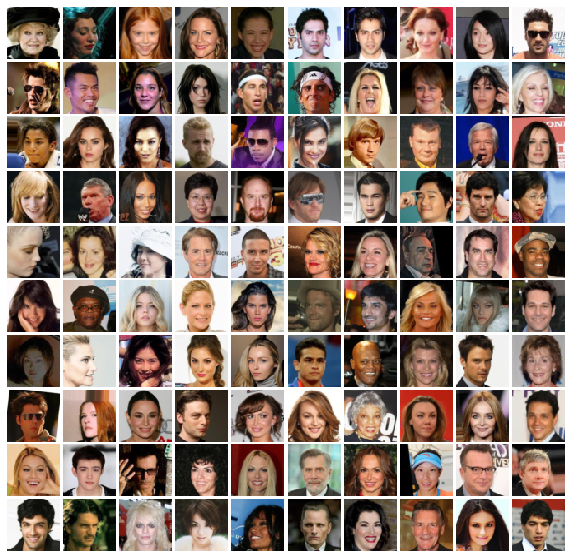

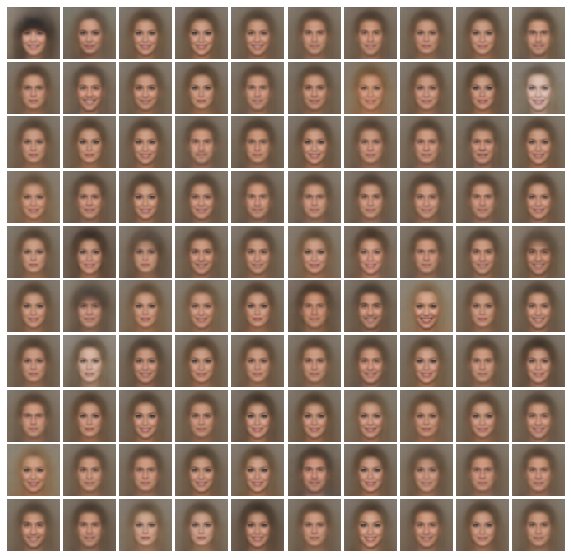

In [123]:
test_mse(model)
show_results(model) 

### Deep Try Criminal Sketch Artist

In [101]:
# Criminal Descriptions

# Criminal1: Man with gray hair, pale skin, and a mustache
Criminal_1_description = ['Male', 'Gray_Hair', 'Pale_Skin', 'Mustache', 'Goatee', '5_o_Clock_Shadow'] # The rest are false
# Criminal2: Young woman with black hair, heavy makeup, wearing a hat
Criminal_2_description = ['Young', 'Black_Hair', 'Heavy_Makeup', 'Wearing_Lipstick', 'Rosy_Cheeks', 'Wearing_Hat', 'No_Beard']
# Criminal3man with glasses and bushy eyebrows
Criminal_3_description = ['Male', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Bushy_Eyebrows']

In [102]:
# Get attribute tensors

ATTR_TO_IX_DICT  = {'Sideburns': 30, 'Black_Hair': 8, 'Wavy_Hair': 33, 'Young': 39, 'Heavy_Makeup': 18, 
                    'Blond_Hair': 9, 'Attractive': 2, '5_o_Clock_Shadow': 0, 'Wearing_Necktie': 38, 
                    'Blurry': 10, 'Double_Chin': 14, 'Brown_Hair': 11, 'Mouth_Slightly_Open': 21, 
                    'Goatee': 16, 'Bald': 4, 'Pointy_Nose': 27, 'Gray_Hair': 17, 'Pale_Skin': 26, 
                    'Arched_Eyebrows': 1, 'Wearing_Hat': 35, 'Receding_Hairline': 28, 'Straight_Hair': 32, 
                    'Big_Nose': 7, 'Rosy_Cheeks': 29, 'Oval_Face': 25, 'Bangs': 5, 'Male': 20, 'Mustache': 22, 
                    'High_Cheekbones': 19, 'No_Beard': 24, 'Eyeglasses': 15, 'Bags_Under_Eyes': 3, 
                    'Wearing_Necklace': 37, 'Wearing_Lipstick': 36, 'Big_Lips': 6, 'Narrow_Eyes': 23, 
                    'Chubby': 13, 'Smiling': 31, 'Bushy_Eyebrows': 12, 'Wearing_Earrings': 34}
def DescriptionToTensor(attr_list):
    attr_tensor = np.zeros(40)
    for attr_name in attr_list:
        attr_index = ATTR_TO_IX_DICT[attr_name]
        attr_tensor[attr_index] = 1
    attr_tensor = np.array([attr_tensor])
    attr_tensor = torch.from_numpy(attr_tensor).float().to("cuda")
    return attr_tensor

Criminal_1_attrs = DescriptionToTensor(Criminal_1_description)
Criminal_2_attrs = DescriptionToTensor(Criminal_2_description)
Criminal_3_attrs = DescriptionToTensor(Criminal_3_description)

In [111]:
# Get image from model
def sketch(mvae_model, attrs):
    mvae_model.eval()
    with torch.no_grad():
        recon_image, recon_attrs, mu, logvar=mvae_model(attrs=attrs)
        image_recon = torch.sigmoid(recon_image)
        image_recon = image_recon.view(1, 3, 64, 64).detach().cpu()
        plt.imshow(image_recon[0].permute(1,2,0))

Man with gray hair, pale skin, and a mustache.


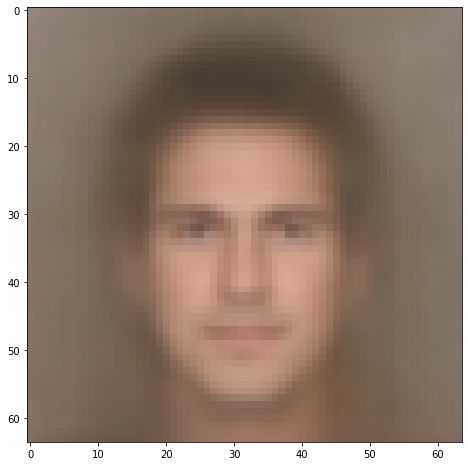

In [112]:
# Sketch criminal one
print("Man with gray hair, pale skin, and a mustache.")
sketch(model, Criminal_1_attrs)

Young woman with black hair, heavy makeup, wearing a hat.


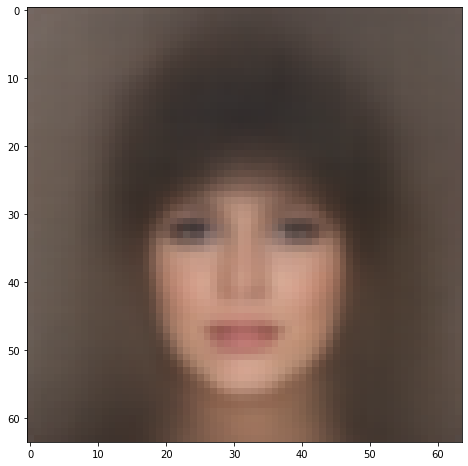

In [113]:
# Sketch criminal two
print("Young woman with black hair, heavy makeup, wearing a hat.")
sketch(model, Criminal_2_attrs)

Chubby young man with glasses and bushy eyebrows.


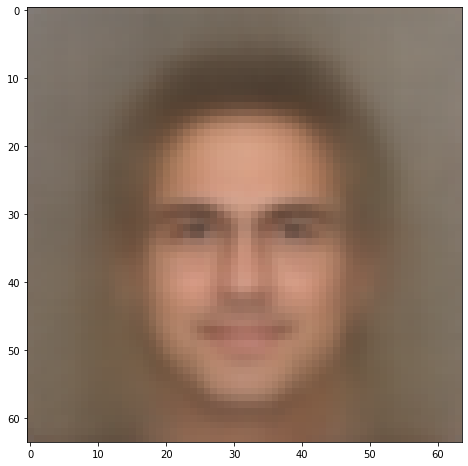

In [114]:
# Sketch criminal three
print("Chubby young man with glasses and bushy eyebrows.")
sketch(model, Criminal_3_attrs)